# Lab Assignment Seven: Recurrent Network Architectures

## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

It's a dataset I got from [kaggle](https://www.kaggle.com/kazanova/sentiment140). Sentiment140 dataset with 1.6 million tweets, which was collected by twitter API.

## 1 Preparation (3 points total)
- [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  
- [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import sys
import os
import tempfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics as mt
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adagrad,Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

print('tensorflow version:',tf.__version__)
print('pandas version:',pd.__version__)
print('keras version:',keras.__version__)
print('numpy version:',np.__version__)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

tensorflow version: 2.3.0
pandas version: 1.2.4
keras version: 2.4.0
numpy version: 1.18.5


### 1.1 Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.

### It's a large dataset contained 1.6 million rows, but I use only 10 thousand rows of them for computational efficiency. I only use the positive and negative labled value from the dataset, which are both 5 thousand.

In [2]:
%%time
chunks = pd.read_csv('./data/sentiment140.csv',names=['target','ids','date','flag','user','text'],usecols=['target','text'],iterator=True,chunksize=5000)
get_pos = False
get_neg = False
for chunk in chunks:
    if ~get_pos and (chunk['target']==4).all():
        chunka = chunk
        get_pos = True
    if ~get_neg and (chunk['target']==0).all():
        chunkb = chunk
        get_neg = True
    if  get_pos and get_neg:
        break

df = pd.concat([chunka,chunkb])
df['target'].replace(4,1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 800000 to 799999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB
CPU times: user 646 ms, sys: 23.9 ms, total: 670 ms
Wall time: 669 ms


### There are not NA data in this data set.

In [3]:
df.isna().sum()

target    0
text      0
dtype: int64

In [4]:
df.target.value_counts()

0    5000
1    5000
Name: target, dtype: int64

### I need to lowercase the letters, so a word contained the same characters could be recongized as the same. Then I remove the url, @userName, punctuations and stop words for the benifit of dimensionality reduction, because they are not essential to the sentiment analysis. 

In [5]:
import re
import string
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def process_text(text_data):
    #make string lower-case
    text_data = text_data.lower()
    #remove url
    text_data = re.sub(urlPattern,'',text_data)
    #remove all @username
    text_data = re.sub(userPattern,'',text_data)
    #remove punctuations
    text_data = text_data.translate(str.maketrans("","",string.punctuation))
    #remove stop words
    tokens = []
    for token in text_data.split():
        if token not in STOPWORDS:
            tokens.append(token)
        
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/amor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['text'] = df.text.apply(lambda x: process_text(x))

### Besides, I would like to remove the stop words here since they are also trivial to the sentiment analysis.

### my final dataset is organized as follows:

|Variable | description|
|----|--------|
|target:      |0 as negative, 1 as positive.|
|text:      |text from tweet|


### I use this dataset to identify whether a tweet is positive or negative, so it's a binary classification task.

In [7]:
df.head()

,target,text
800000,1,love u guys r best
800001,1,im meeting one besties tonight cant wait girl ...
800002,1,thanks twitter add sunisa got meet hin show dc...
800003,1,sick really cheap hurts much eat real food plu...
800004,1,effect everyone


### I would use word tokenization with a specific length of sequence. The reason I used word tokenization is because it's most common method and I want to focus the meaning of the word to do sentiment analysis. The forced specific length of sequence is due to computational efficiency by using only one computation graph.

### The entire vocabulary of the dataset is around 14 thousand, however, I used 8000 of them for computational efficiency though I can use all of them. The maximum sequence of the word is 22 since I have tested, so I just use 22. The purpose to do these is to save time in training model.

In [8]:
%%time
NUM_TOP_WORDS = 8000 # use top 5000 words
MAX_ART_LEN = 22

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df.text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df.text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences,maxlen=MAX_ART_LEN)
y = df.target
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Found 14402 unique tokens. Distilled to 8000 top words.
Shape of data tensor: (10000, 22)
Shape of label tensor: (10000,)
7999
CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 134 ms


### 1.2 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### I would use accuracy as the metric for my classification task because I have equal number of samples belonging to each class. In terms of even to any class, I can easily get rid of the hassle that a model always says yes all the time which may occur in an imbalanced dataset, though high accuracy. Besides, for the scenario of sentiment analysis, the accuracy of the algorithm represents how confidence level for the third party to be relied on to make decisions.  

(array([5000.,    0.,    0., 5000.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <BarContainer object of 4 artists>)

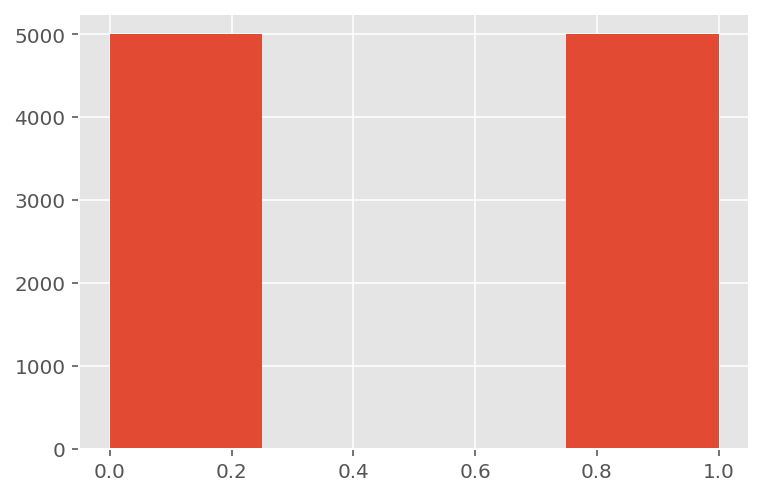

In [9]:
plt.hist(y,bins=4)

### 1.3 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

### I would use 80-20 traning and testing split because it's a totally balanced dataset. Besides, to improve computational efficiency, I do not use K-fold here though I think it is good idea to evaluate my model.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 22)
(2000, 22)
(8000,)
(2000,)


## 2. Modeling (6 points total)
- [3 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, OR both). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them.
- [1 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 
- [2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior. 

### During the training, I use early stopping by monitoring the val_loss with patience=10 and reducing the learning rate by monitoring val_loss with patience 5 in order to prevent overfitting.

In [11]:
def plot_metrics(history,label):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train ' + label)
        plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val ' + label)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric != 'loss':
            plt.ylim([0,1])
        plt.title('{}'.format(metric))
        plt.legend()
        plt.show()

def evaluate_model(model,X_train,y_train,X_test,y_test,model_name,epochs=100,batch_size=128,verbose=1): 
    h = model.fit(X_train,
        y_train, 
        epochs=epochs, 
        verbose=verbose,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[EarlyStopping(monitor = 'val_loss', patience = 10),ReduceLROnPlateau(monitor='val_loss', patience=5)],
        validation_data=(X_test, y_test)
    )
    plot_metrics(h,model_name)
    # now lets see how well the model performed
    yscore = model.predict(X_test).flatten()
    yhat = np.around(yscore)
    acc = mt.accuracy_score(y_test,yhat)
    fp,tp,_ = mt.roc_curve(y_test,yscore)
    # cm = mt.confusion_matrix(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm,annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model_name,acc))
    plt.show()
    return {'history':h,'cm':cm,'acc':acc,'fp':fp,'tp':tp}

In [12]:
def compare_model(model1_eval,model2_eval,model1_name,model2_name):
    fp1 = model1_eval['fp']
    tp1 = model1_eval['tp']
    fp2 = model2_eval['fp']
    tp2 = model2_eval['tp']
    plt.plot(fp1, tp1, label='{} ROC (AUC {:.3f})'.format(model1_name,auc(fp1,tp1)) , linewidth=2)
    plt.plot(fp2, tp2, label='{} ROC (AUC {:.3f})'.format(model2_name,auc(fp2,tp2)), linewidth=2, linestyle='--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    ax = plt.gca()
    # ax.set_aspect('equal')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(15,5))
    acc1 = model1_eval['acc']
    acc2 = model2_eval['acc']
    cm1 = model1_eval['cm']
    cm2 = model2_eval['cm']

    plt.subplot(1,2,1)
    sns.heatmap(cm1, annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model1_name,acc1))

    plt.subplot(1,2,2)
    sns.heatmap(cm2, annot=True, fmt='.2f')
    plt.title('{}: {}'.format(model2_name,acc2))

    plt.show()

    d = np.abs(acc1-acc2)
    v = acc1*(1-acc1)/X_test.shape[0] + acc2*(1-acc2)/X_test.shape[0]
    print('The difference of {} and {} is {},{} '.format(model1_name,model2_name,d-1.96*np.sqrt(v),d+1.96*np.sqrt(v)))


### I used an pre-trained embedding layer of GloVe

In [13]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.300d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 400000 word vectors.
Embedding Shape: (14403, 300) 
 Total words found: 10505 
 Percentage: 72.93619384850378
CPU times: user 14.6 s, sys: 173 ms, total: 14.7 s
Wall time: 14.7 s


### This is a RNN model using LSTM, which is called LSTM1

In [14]:
NUM_CLASSES = 1
rnn1 = Sequential(name='LSTM1')
rnn1.add(embedding_layer)
rnn1.add(LSTM(16))
rnn1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn1.compile(loss='mean_squared_error', 
              optimizer='RMSprop', 
              metrics=['accuracy'])
rnn1.summary(line_length=90)

Model: "LSTM1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 22, 300)                     4320900       
__________________________________________________________________________________________
lstm (LSTM)                             (None, 16)                          20288         
__________________________________________________________________________________________
dense (Dense)                           (None, 1)                           17            
Total params: 4,341,205
Trainable params: 20,305
Non-trainable params: 4,320,900
__________________________________________________________________________________________


Epoch 1/100
20/20 [==============================] - 0s 14ms/step - loss: 0.2287 - accuracy: 0.6309 - val_loss: 0.2124 - val_accuracy: 0.6735
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1999 - accuracy: 0.7011 - val_loss: 0.1971 - val_accuracy: 0.6945
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1871 - accuracy: 0.7219 - val_loss: 0.1882 - val_accuracy: 0.7050
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1788 - accuracy: 0.7360 - val_loss: 0.1848 - val_accuracy: 0.7180
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1730 - accuracy: 0.7466 - val_loss: 0.1822 - val_accuracy: 0.7250
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1677 - accuracy: 0.7526 - val_loss: 0.1789 - val_accuracy: 0.7305
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1637 - accuracy: 0.7636 - val_loss: 0.1775 - val_accuracy: 0.7285
Epoch 8/100


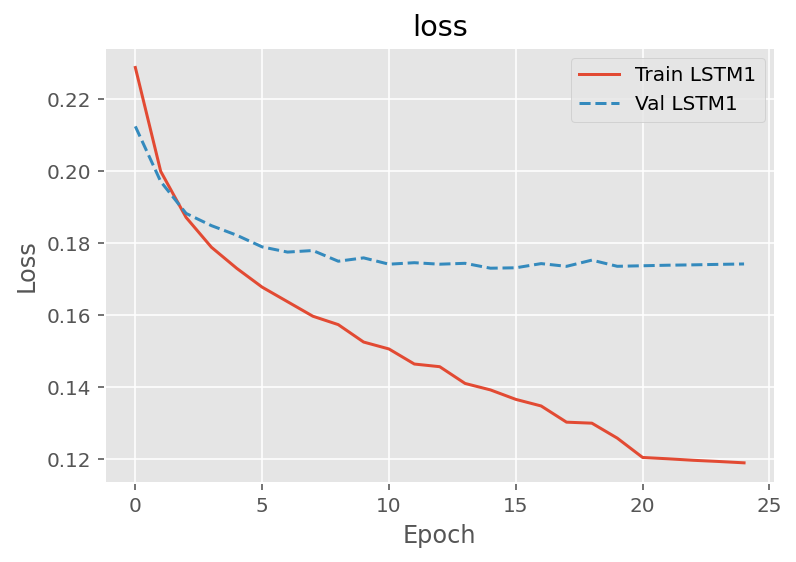

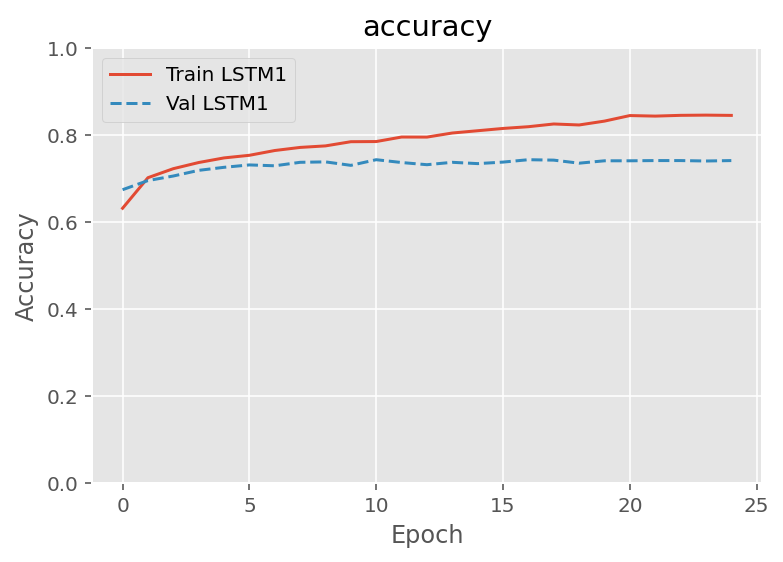

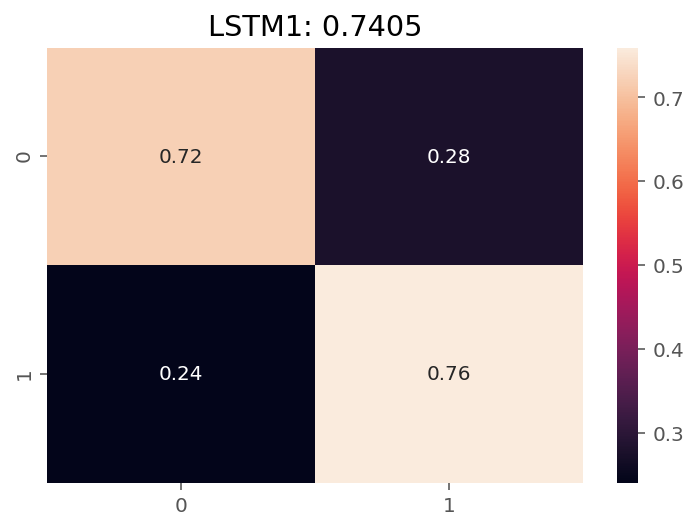

CPU times: user 4.93 s, sys: 474 ms, total: 5.41 s
Wall time: 4.2 s


In [15]:
%%time
rnn1_eval = evaluate_model(rnn1,X_train,y_train,X_test,y_test,rnn1.name,batch_size=400,verbose=1)

### This is a RNN model using Bidirectional LSTM with some hyperprameters altered, which is called LSTM2

In [16]:
l2_lambda = 0.0001
rnn2 = Sequential(name='LSTM2')
rnn2.add(embedding_layer)
rnn2.add(Dropout(0.5))
rnn2.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5)))
rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn2.summary(line_length=90)

Model: "LSTM2"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 22, 300)                     4320900       
__________________________________________________________________________________________
dropout (Dropout)                       (None, 22, 300)                     0             
__________________________________________________________________________________________
bidirectional (Bidirectional)           (None, 256)                         439296        
__________________________________________________________________________________________
dense_1 (Dense)                         (None, 1)                           257           
Total params: 4,760,453
Trainable params: 439,553
Non-trainable params: 4,320,900
____________________________________________________________________________________

Epoch 1/100
20/20 [==============================] - 1s 70ms/step - loss: 0.6586 - accuracy: 0.6056 - val_loss: 0.5771 - val_accuracy: 0.6970
Epoch 2/100
20/20 [==============================] - 1s 59ms/step - loss: 0.6000 - accuracy: 0.6725 - val_loss: 0.5521 - val_accuracy: 0.7060
Epoch 3/100
20/20 [==============================] - 1s 60ms/step - loss: 0.5863 - accuracy: 0.6825 - val_loss: 0.5440 - val_accuracy: 0.7250
Epoch 4/100
20/20 [==============================] - 1s 60ms/step - loss: 0.5814 - accuracy: 0.6881 - val_loss: 0.5344 - val_accuracy: 0.7255
Epoch 5/100
20/20 [==============================] - 1s 59ms/step - loss: 0.5716 - accuracy: 0.6964 - val_loss: 0.5288 - val_accuracy: 0.7260
Epoch 6/100
20/20 [==============================] - 1s 59ms/step - loss: 0.5631 - accuracy: 0.7010 - val_loss: 0.5264 - val_accuracy: 0.7310
Epoch 7/100
20/20 [==============================] - 1s 60ms/step - loss: 0.5540 - accuracy: 0.7031 - val_loss: 0.5175 - val_accuracy: 0.7385
Epoch 

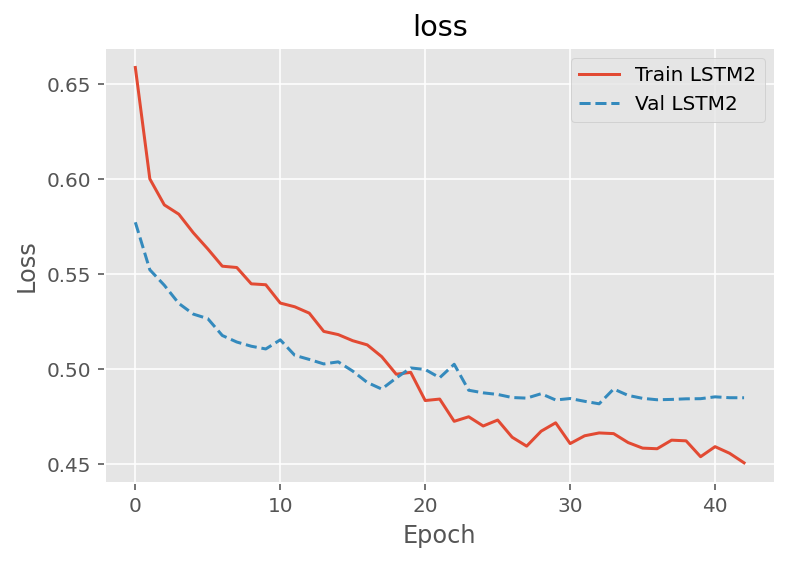

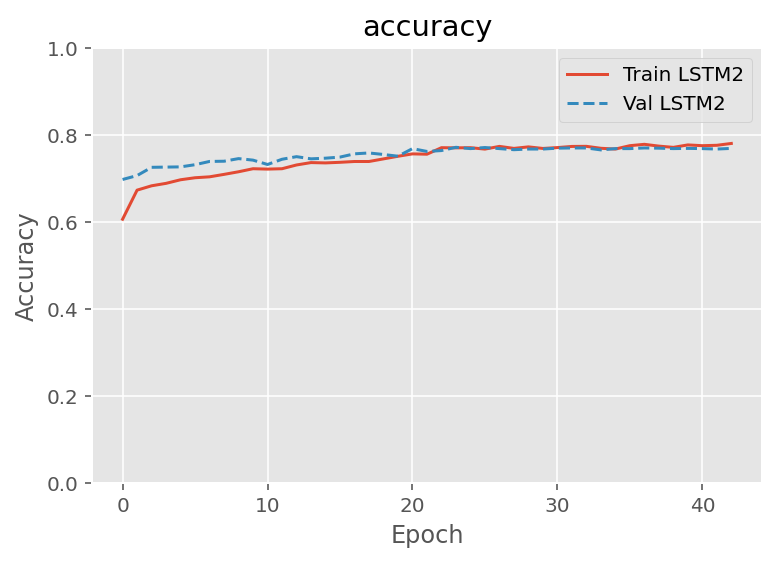

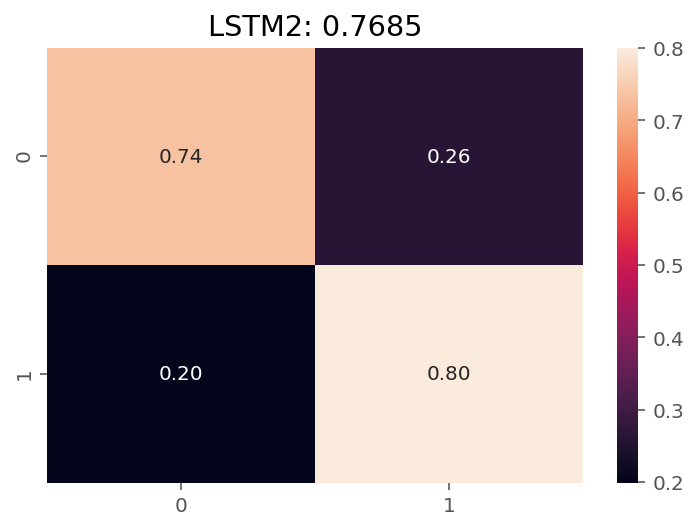

CPU times: user 59.8 s, sys: 9.52 s, total: 1min 9s
Wall time: 56.2 s


In [17]:
%%time
rnn2_eval = evaluate_model(rnn2,X_train,y_train,X_test,y_test,rnn2.name,batch_size=400,verbose=1)

### This is a RNN model using GRU, which is called GRU1

In [18]:
rnn3 = Sequential(name='GRU1')
rnn3.add(embedding_layer)
rnn3.add(GRU(16))
rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn3.compile(loss='mean_squared_error', 
              optimizer='RMSprop', 
              metrics=['accuracy'])
rnn3.summary(line_length=90)

Model: "GRU1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 22, 300)                     4320900       
__________________________________________________________________________________________
gru (GRU)                               (None, 16)                          15264         
__________________________________________________________________________________________
dense_2 (Dense)                         (None, 1)                           17            
Total params: 4,336,181
Trainable params: 15,281
Non-trainable params: 4,320,900
__________________________________________________________________________________________


Epoch 1/100
20/20 [==============================] - 0s 12ms/step - loss: 0.2294 - accuracy: 0.6205 - val_loss: 0.2161 - val_accuracy: 0.6700
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2075 - accuracy: 0.6821 - val_loss: 0.2017 - val_accuracy: 0.6900
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1933 - accuracy: 0.7097 - val_loss: 0.1909 - val_accuracy: 0.7090
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1826 - accuracy: 0.7300 - val_loss: 0.1828 - val_accuracy: 0.7270
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1745 - accuracy: 0.7435 - val_loss: 0.1789 - val_accuracy: 0.7340
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1696 - accuracy: 0.7531 - val_loss: 0.1759 - val_accuracy: 0.7385
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1661 - accuracy: 0.7600 - val_loss: 0.1754 - val_accuracy: 0.7355
Epoch 8/100


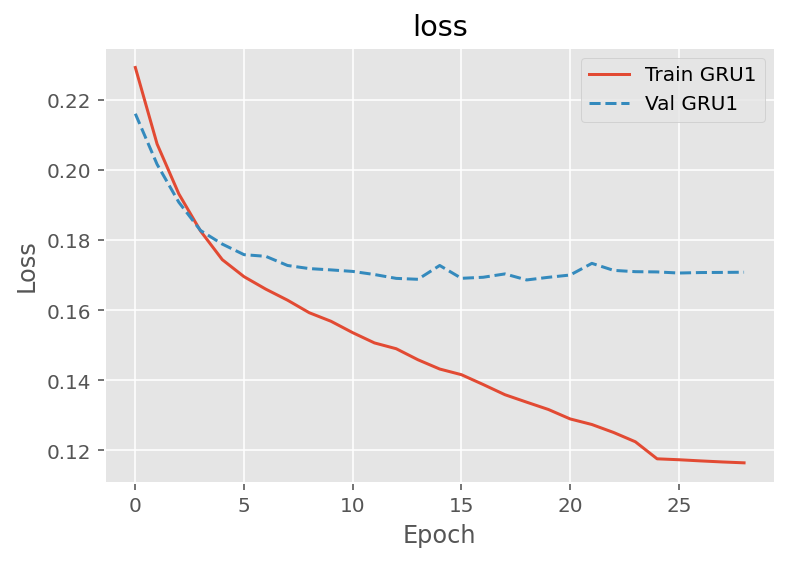

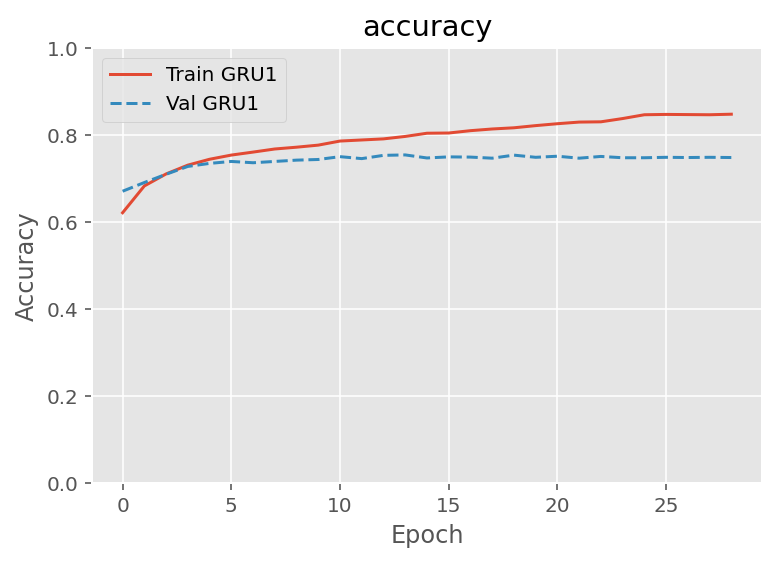

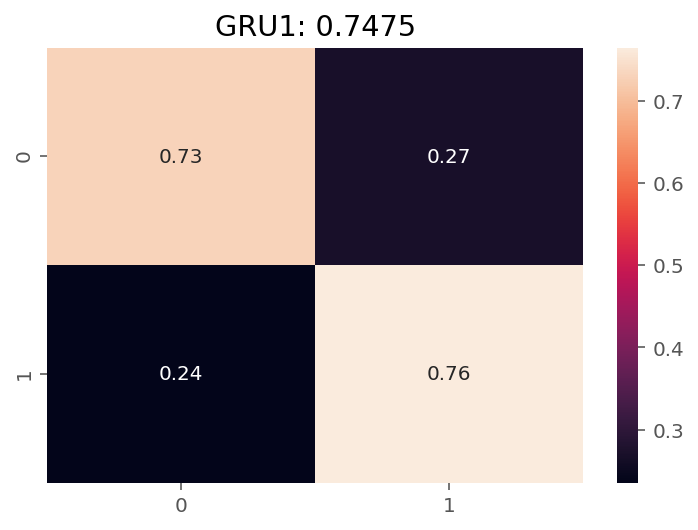

CPU times: user 4.93 s, sys: 392 ms, total: 5.32 s
Wall time: 4 s


In [19]:
%%time
rnn3_eval = evaluate_model(rnn3,X_train,y_train,X_test,y_test,rnn3.name,batch_size=400,verbose=1)

### This is a RNN model using Bidirectional GRU with some hyperprameters altered, which is called GRU2.

In [20]:
rnn4 = Sequential(name='GRU2')
rnn4.add(embedding_layer)
rnn4.add(Dropout(0.5))
rnn4.add(Bidirectional(GRU(128,dropout=0.5, recurrent_dropout=0.5)))
rnn4.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn4.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn4.summary(line_length=90)

Model: "GRU2"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 22, 300)                     4320900       
__________________________________________________________________________________________
dropout_1 (Dropout)                     (None, 22, 300)                     0             
__________________________________________________________________________________________
bidirectional_1 (Bidirectional)         (None, 256)                         330240        
__________________________________________________________________________________________
dense_3 (Dense)                         (None, 1)                           257           
Total params: 4,651,397
Trainable params: 330,497
Non-trainable params: 4,320,900
_____________________________________________________________________________________

Epoch 1/100
20/20 [==============================] - 1s 61ms/step - loss: 0.6684 - accuracy: 0.5849 - val_loss: 0.6162 - val_accuracy: 0.6705
Epoch 2/100
20/20 [==============================] - 1s 49ms/step - loss: 0.6196 - accuracy: 0.6528 - val_loss: 0.5663 - val_accuracy: 0.7005
Epoch 3/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5993 - accuracy: 0.6734 - val_loss: 0.5504 - val_accuracy: 0.7110
Epoch 4/100
20/20 [==============================] - 1s 49ms/step - loss: 0.5892 - accuracy: 0.6826 - val_loss: 0.5452 - val_accuracy: 0.7185
Epoch 5/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5860 - accuracy: 0.6833 - val_loss: 0.5371 - val_accuracy: 0.7255
Epoch 6/100
20/20 [==============================] - 1s 49ms/step - loss: 0.5766 - accuracy: 0.6811 - val_loss: 0.5292 - val_accuracy: 0.7345
Epoch 7/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5722 - accuracy: 0.6950 - val_loss: 0.5337 - val_accuracy: 0.7215
Epoch 

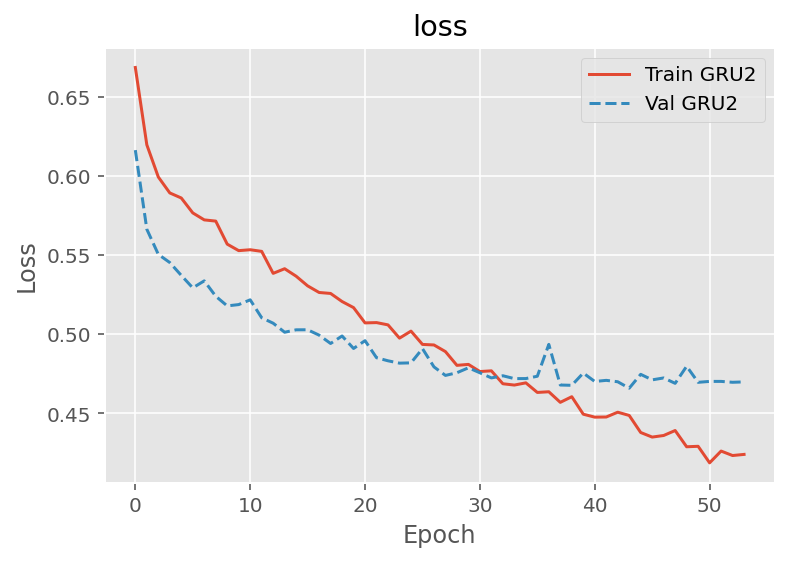

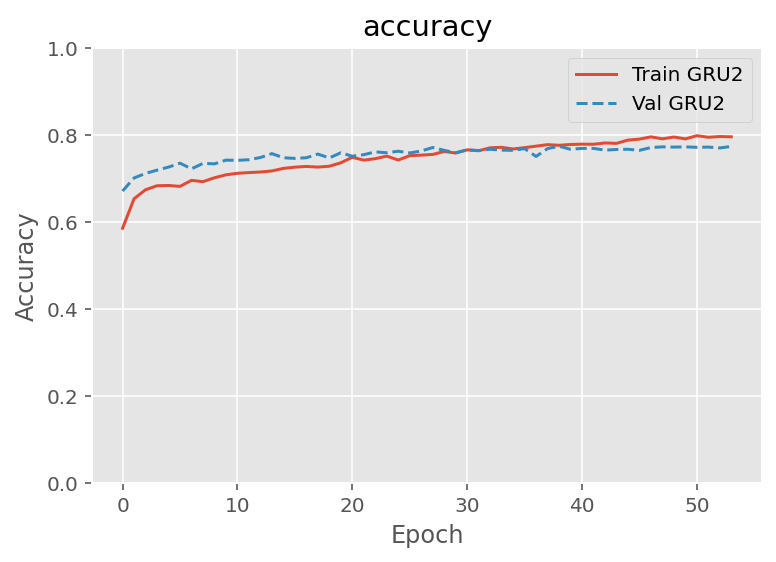

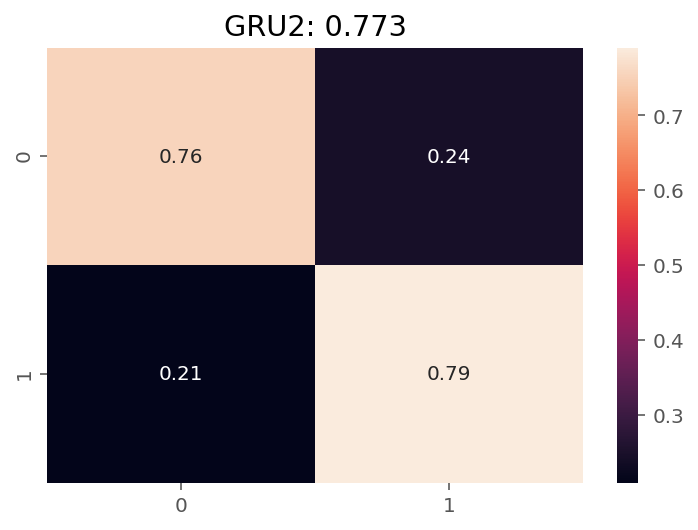

CPU times: user 1min 5s, sys: 10.3 s, total: 1min 15s
Wall time: 58.6 s


In [21]:
%%time
rnn4_eval = evaluate_model(rnn4,X_train,y_train,X_test,y_test,rnn4.name,batch_size=400,verbose=1)

### Based on the roc curve and accuracy comparison, the model LSTM2 is better than LSTM1.

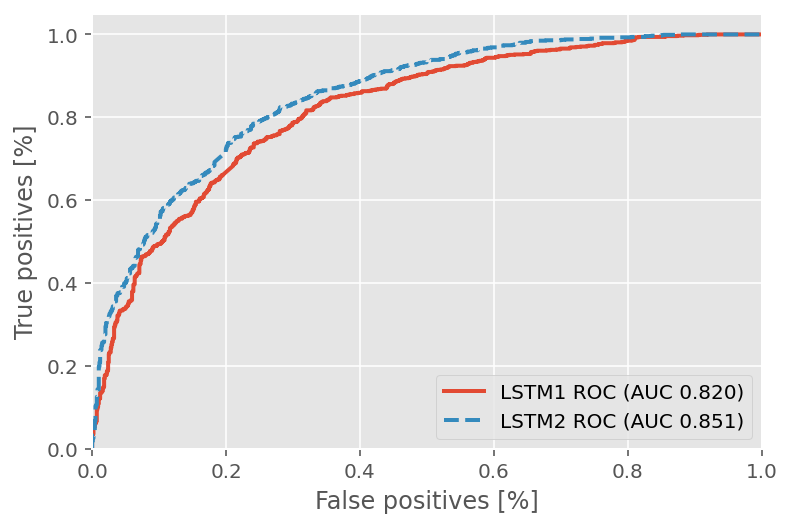

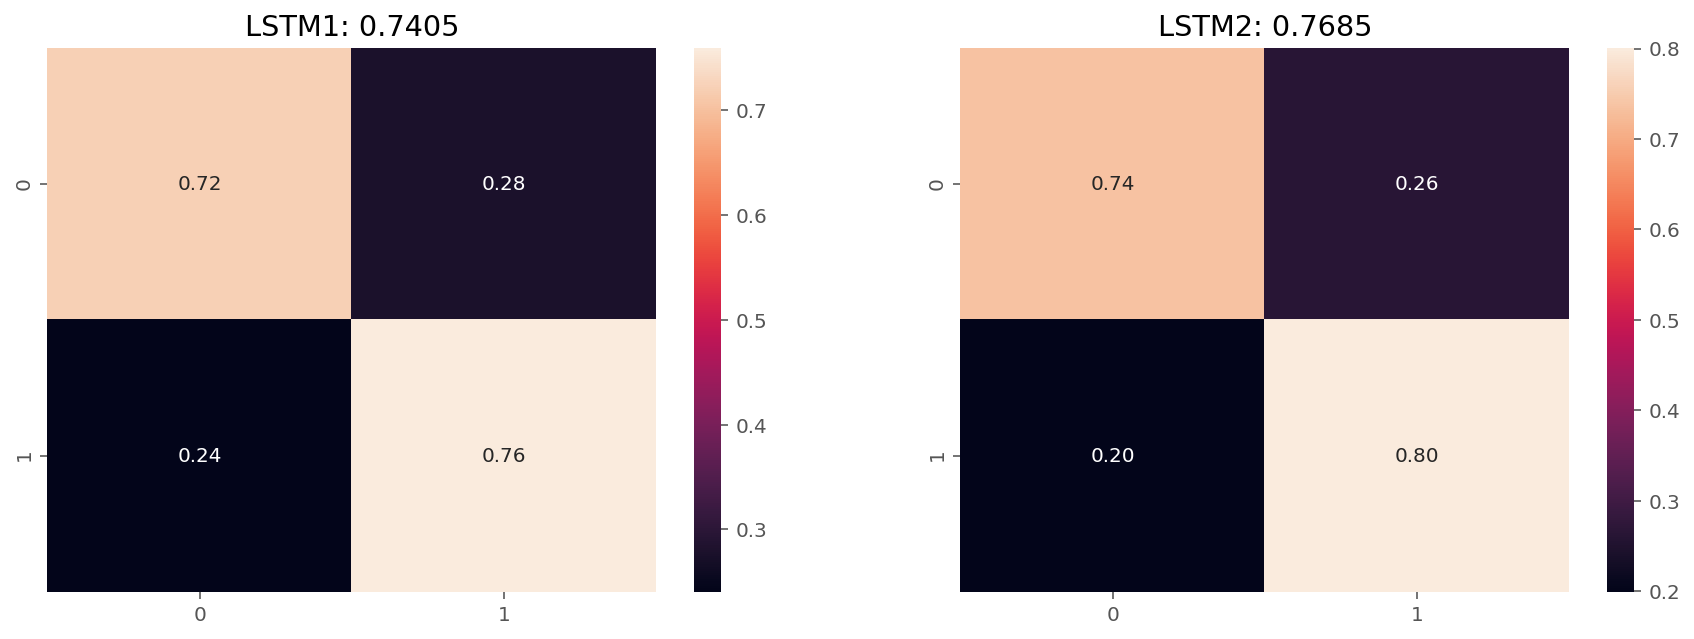

The difference of LSTM1 and LSTM2 is 0.00133868619141201,0.05466131380858782 


In [22]:
compare_model(rnn1_eval,rnn2_eval,rnn1.name,rnn2.name)

### Based on the roc curve and accuracy comparison, the model GRU2 is better than GRU1.

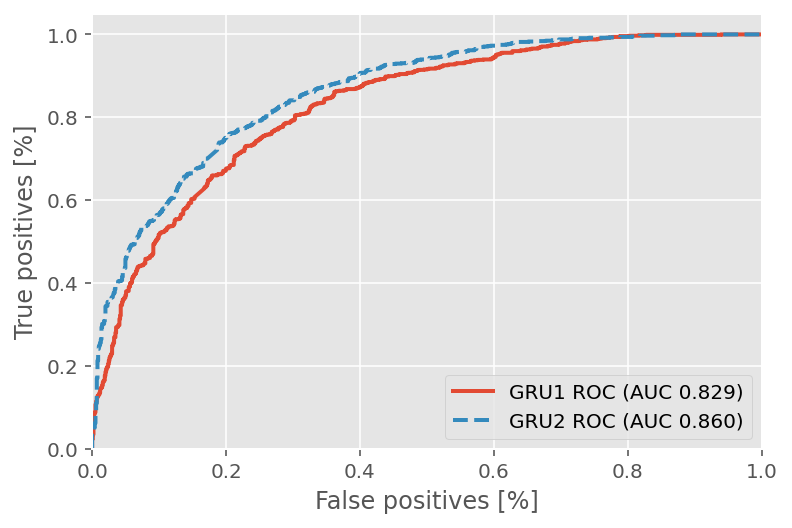

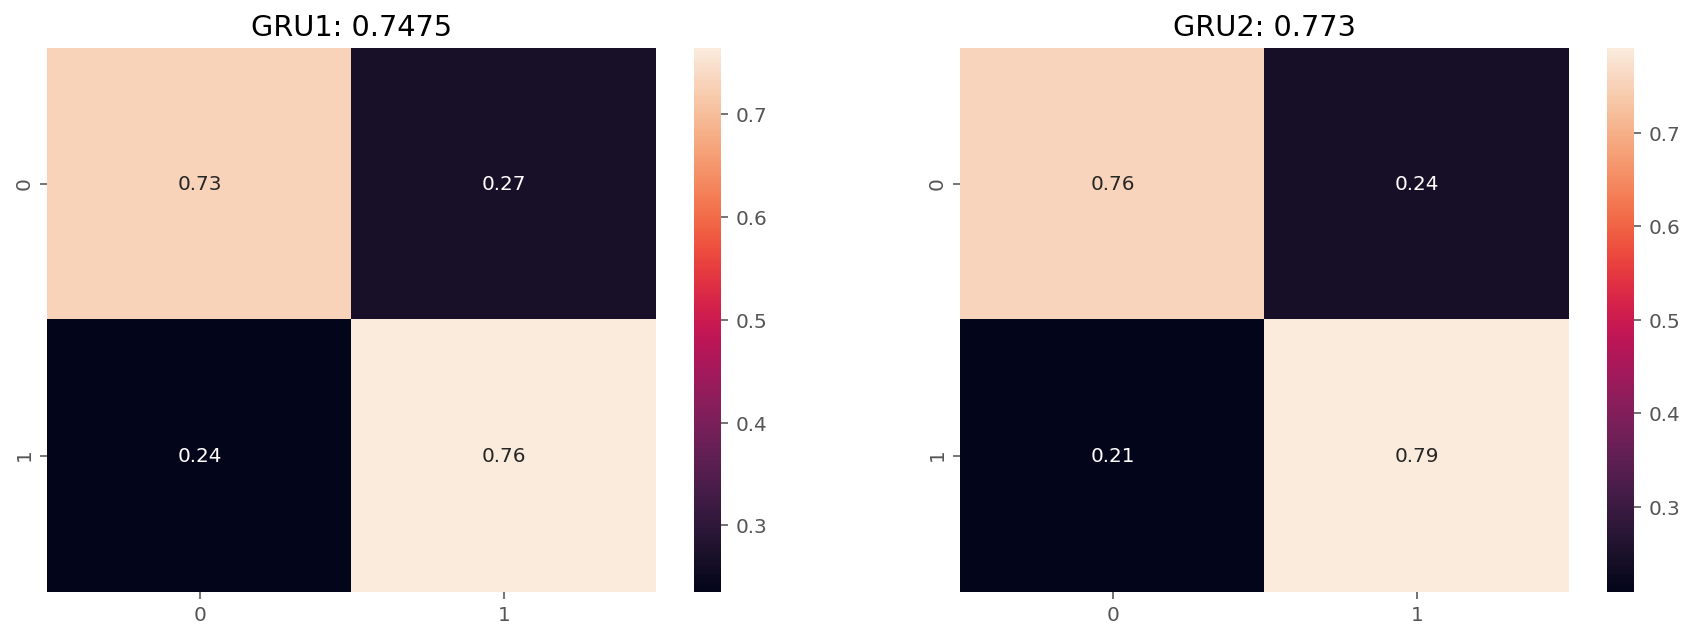

The difference of GRU1 and GRU2 is -0.0009496444550773052,0.05194964445507724 


In [23]:
compare_model(rnn3_eval,rnn4_eval,rnn3.name,rnn4.name)

### It seems that, based on the accuracy and roc curve, the model GRU2 is slightly better than LSTM2.

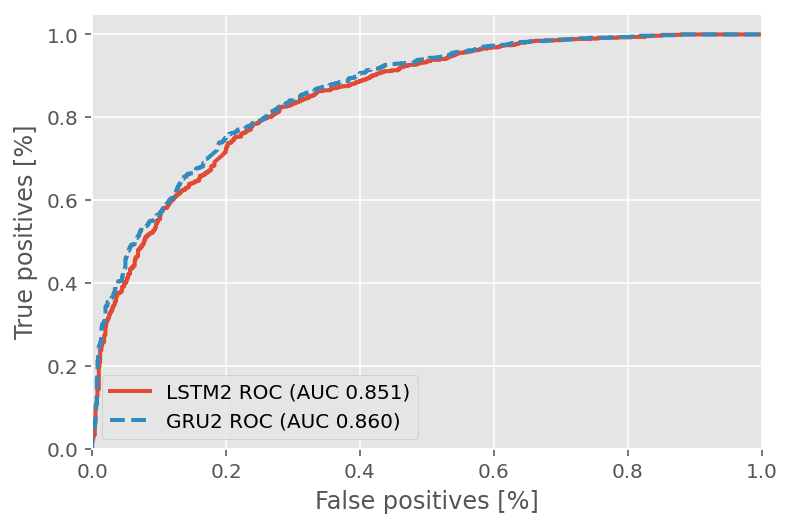

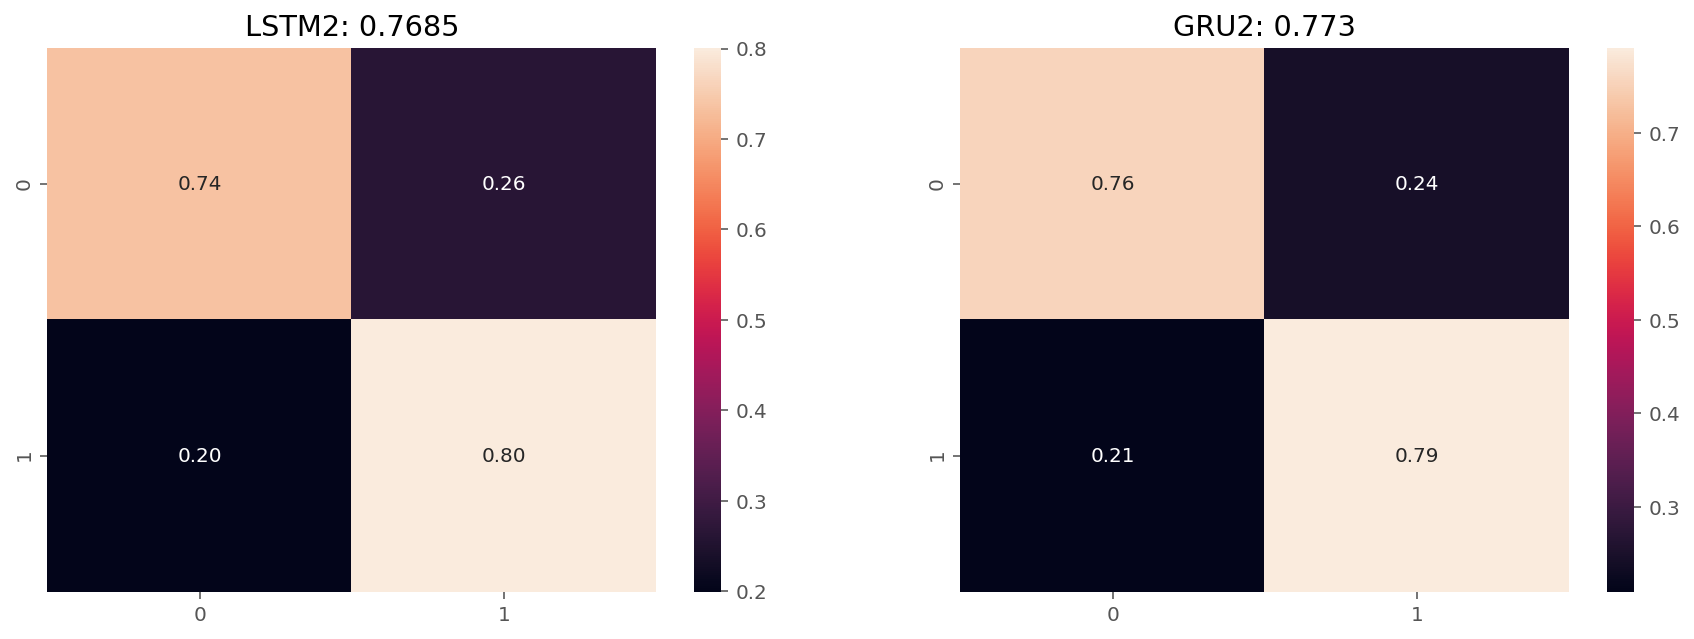

The difference of LSTM2 and GRU2 is -0.021553212911270596,0.030553212911270715 


In [24]:
compare_model(rnn2_eval,rnn4_eval,rnn2.name,rnn4.name)

### 2.2 Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

### I added another GRU on the previous model GRU2 and formed the model GRU3

In [25]:
rnn5 = Sequential(name='GRU3')
rnn5.add(embedding_layer)
rnn5.add(Dropout(0.5))
rnn5.add(Bidirectional(GRU(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
rnn5.add(Bidirectional(GRU(128,dropout=0.5, recurrent_dropout=0.5)))
rnn5.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn5.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn5.summary(line_length=90)

Model: "GRU3"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 22, 300)                     4320900       
__________________________________________________________________________________________
dropout_2 (Dropout)                     (None, 22, 300)                     0             
__________________________________________________________________________________________
bidirectional_2 (Bidirectional)         (None, 22, 256)                     330240        
__________________________________________________________________________________________
bidirectional_3 (Bidirectional)         (None, 256)                         296448        
__________________________________________________________________________________________
dense_4 (Dense)                         (None, 1)                           

Epoch 1/100
20/20 [==============================] - 2s 121ms/step - loss: 0.6625 - accuracy: 0.5938 - val_loss: 0.5893 - val_accuracy: 0.6855
Epoch 2/100
20/20 [==============================] - 2s 102ms/step - loss: 0.6138 - accuracy: 0.6612 - val_loss: 0.5503 - val_accuracy: 0.7205
Epoch 3/100
20/20 [==============================] - 2s 102ms/step - loss: 0.5979 - accuracy: 0.6702 - val_loss: 0.5458 - val_accuracy: 0.7200
Epoch 4/100
20/20 [==============================] - 2s 102ms/step - loss: 0.5936 - accuracy: 0.6745 - val_loss: 0.5544 - val_accuracy: 0.7110
Epoch 5/100
20/20 [==============================] - 2s 102ms/step - loss: 0.5880 - accuracy: 0.6816 - val_loss: 0.5390 - val_accuracy: 0.7255
Epoch 6/100
20/20 [==============================] - 2s 102ms/step - loss: 0.5802 - accuracy: 0.6801 - val_loss: 0.5308 - val_accuracy: 0.7345
Epoch 7/100
20/20 [==============================] - 2s 102ms/step - loss: 0.5659 - accuracy: 0.7014 - val_loss: 0.5208 - val_accuracy: 0.7335

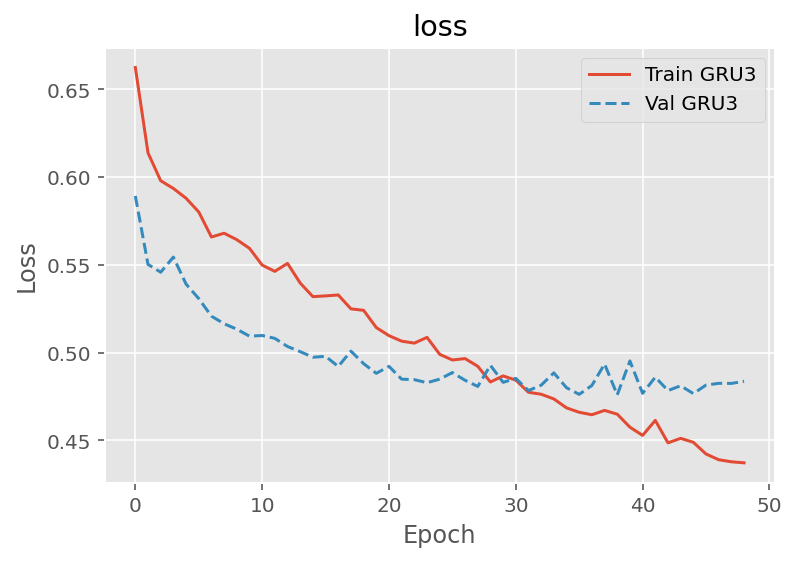

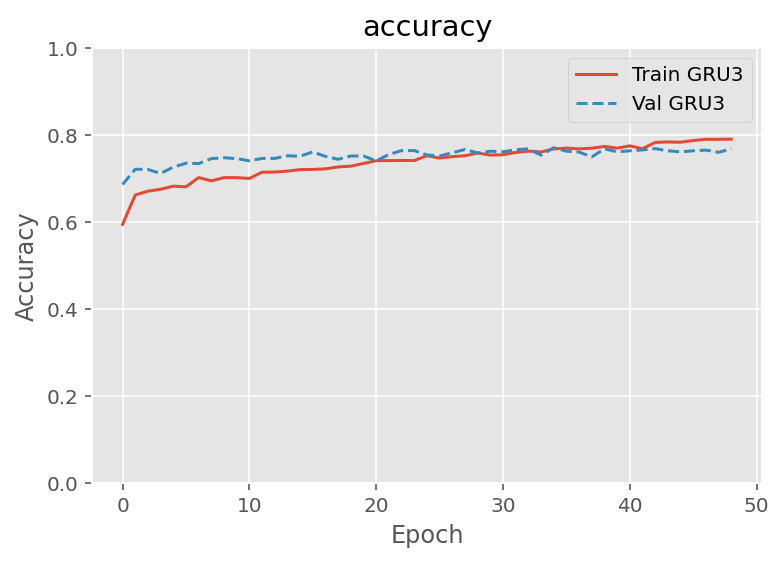

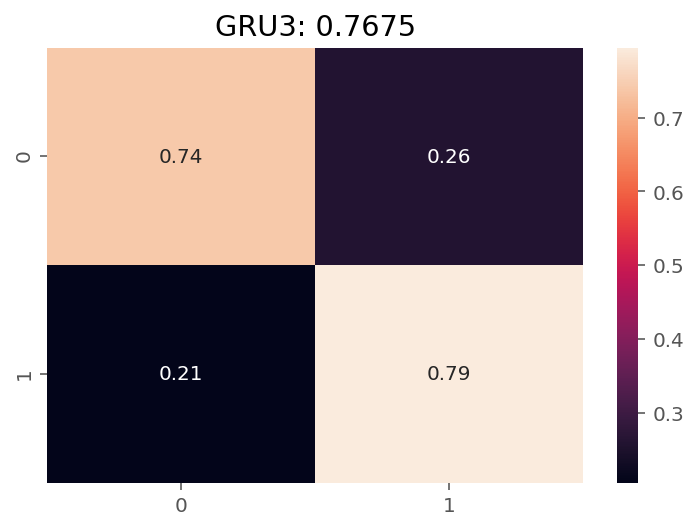

CPU times: user 2min, sys: 23.2 s, total: 2min 23s
Wall time: 1min 48s


In [26]:
%%time
rnn5_eval = evaluate_model(rnn5,X_train,y_train,X_test,y_test,rnn5.name,batch_size=400,verbose=1)

### Based on the roc curve and accuracy, the model GRU2 looks slightly better than GRU3.

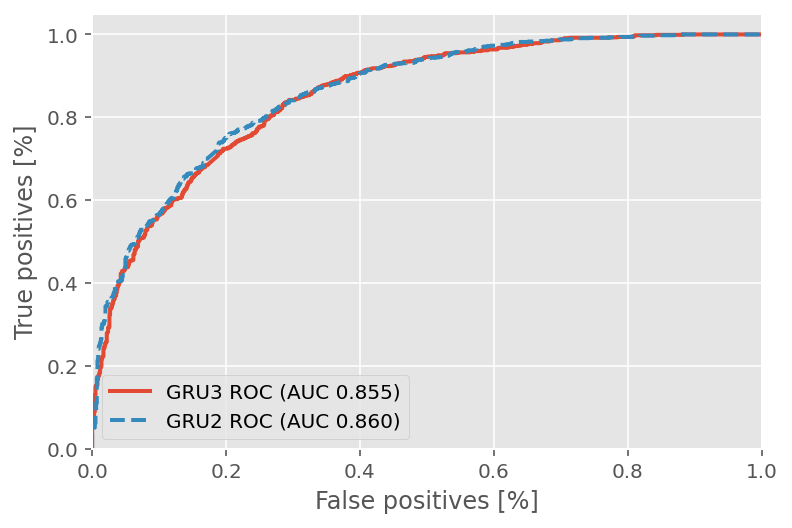

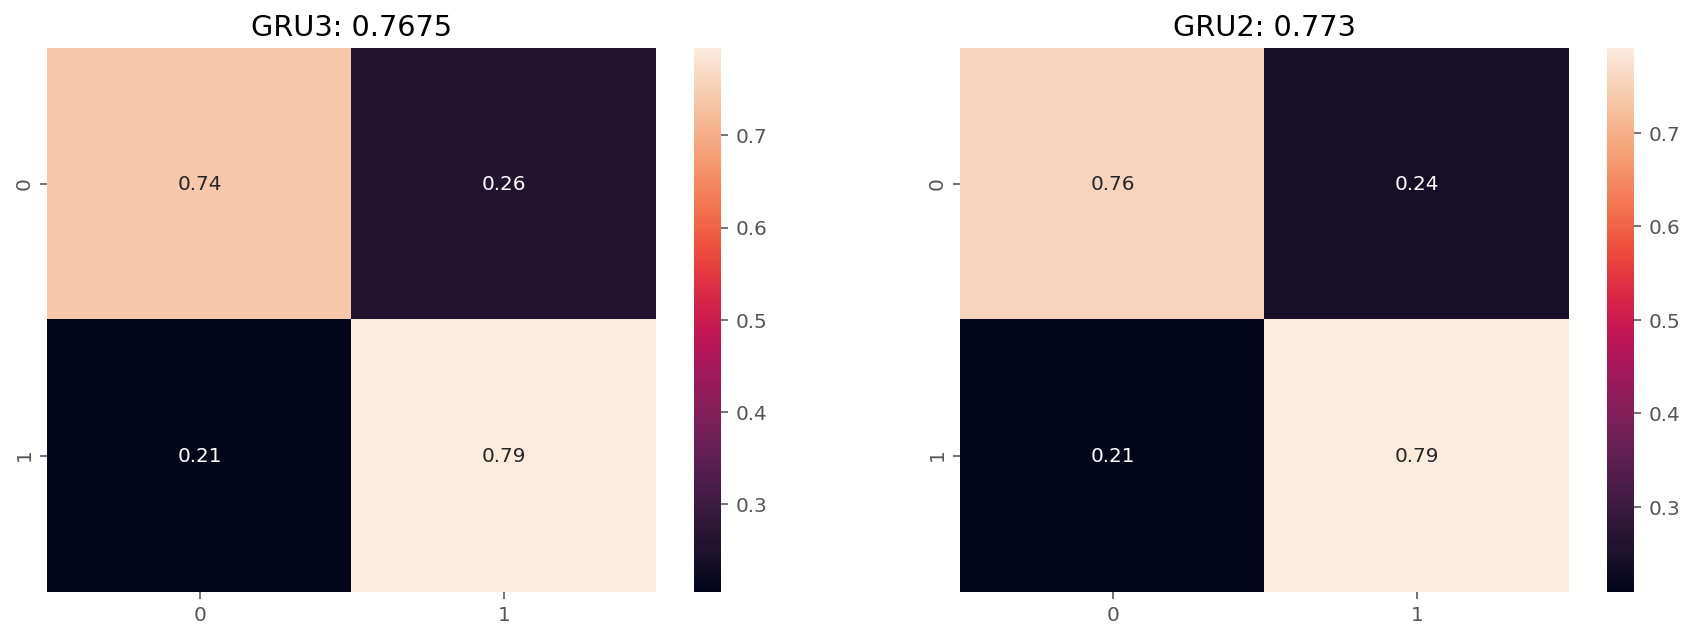

The difference of GRU3 and GRU2 is -0.020572964001048993,0.031572964001049114 


In [27]:
compare_model(rnn5_eval,rnn4_eval,rnn5.name,rnn4.name)

## Exceptional Work (1 points total)
- You have free reign to provide additional analyses.
- One idea (required for 7000 level students to do one of these options):
    - Option 1: Use dimensionality reduction (choose an appropriate method from this list: t-SNE, SVD, PCA, or UMAP) to visualize the word embeddings of a subset of words in your vocabulary that you expect to have an analogy that can be captured by the embedding. Try to interpret if an analogy exists, show the vectors that support/refute the analogy, and interpret your findings. 
    - Options 2: Use the ConceptNet Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 
- Another Idea (NOT required): Try to create a RNN for generating novel text. 

### I used the ConceptNet Numberbatch embedding and compare to GloVe

In [28]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/numberbatch-en-19.08.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 516783 word vectors.
Embedding Shape: (14403, 300) 
 Total words found: 10016 
 Percentage: 69.54106783309032
CPU times: user 18.3 s, sys: 121 ms, total: 18.4 s
Wall time: 18.4 s


In [29]:
rnn6 = Sequential(name='GRU4')
rnn6.add(embedding_layer)
rnn6.add(Dropout(0.5))
rnn6.add(Bidirectional(GRU(128,dropout=0.5, recurrent_dropout=0.5)))
rnn6.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn6.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn6.summary(line_length=90)

Model: "GRU4"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding_1 (Embedding)                 (None, 22, 300)                     4320900       
__________________________________________________________________________________________
dropout_3 (Dropout)                     (None, 22, 300)                     0             
__________________________________________________________________________________________
bidirectional_4 (Bidirectional)         (None, 256)                         330240        
__________________________________________________________________________________________
dense_5 (Dense)                         (None, 1)                           257           
Total params: 4,651,397
Trainable params: 330,497
Non-trainable params: 4,320,900
_____________________________________________________________________________________

Epoch 1/100
20/20 [==============================] - 1s 62ms/step - loss: 0.6799 - accuracy: 0.5934 - val_loss: 0.6586 - val_accuracy: 0.7020
Epoch 2/100
20/20 [==============================] - 1s 50ms/step - loss: 0.6313 - accuracy: 0.6597 - val_loss: 0.5870 - val_accuracy: 0.6790
Epoch 3/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5976 - accuracy: 0.6764 - val_loss: 0.5505 - val_accuracy: 0.7345
Epoch 4/100
20/20 [==============================] - 1s 49ms/step - loss: 0.5907 - accuracy: 0.6805 - val_loss: 0.5453 - val_accuracy: 0.7370
Epoch 5/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5787 - accuracy: 0.6936 - val_loss: 0.5282 - val_accuracy: 0.7475
Epoch 6/100
20/20 [==============================] - 1s 50ms/step - loss: 0.5727 - accuracy: 0.6908 - val_loss: 0.5260 - val_accuracy: 0.7450
Epoch 7/100
20/20 [==============================] - 1s 49ms/step - loss: 0.5705 - accuracy: 0.6955 - val_loss: 0.5236 - val_accuracy: 0.7455
Epoch 

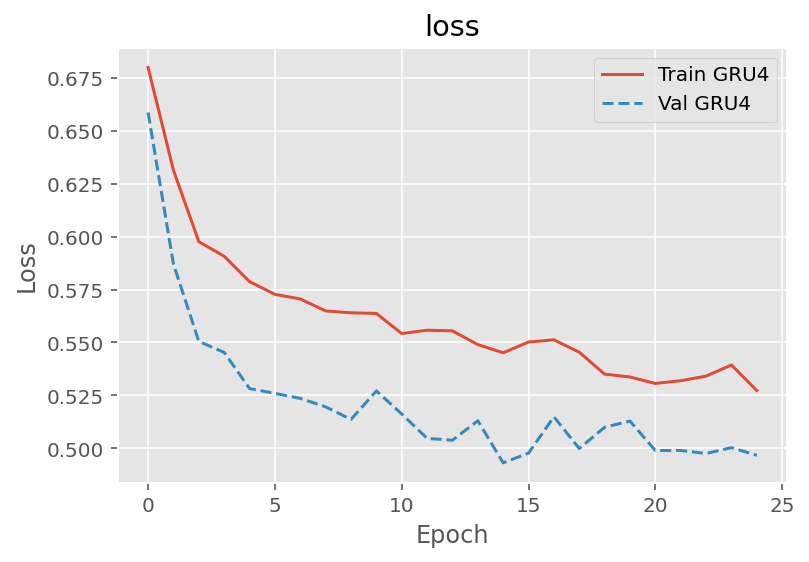

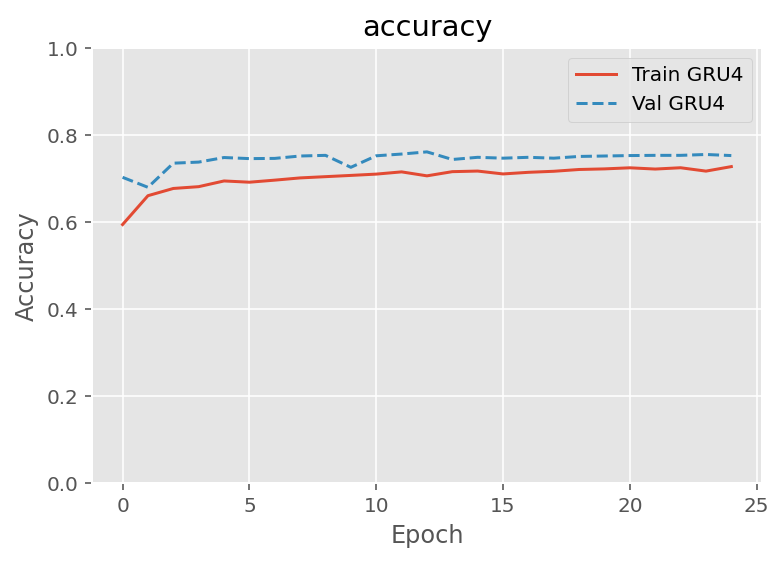

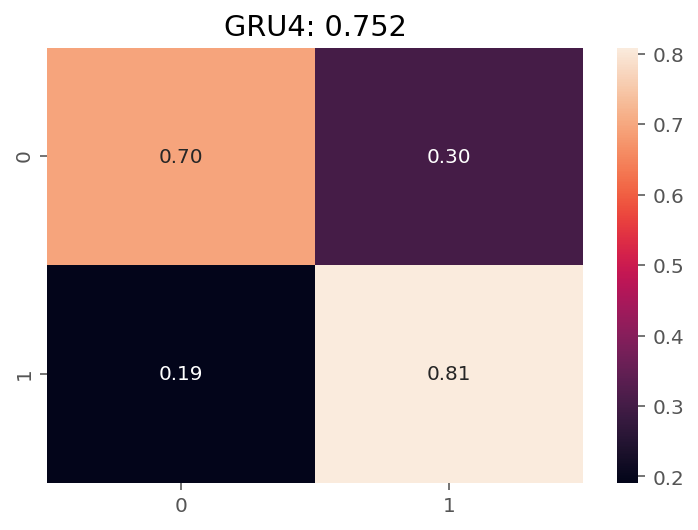

CPU times: user 31.7 s, sys: 4.49 s, total: 36.2 s
Wall time: 28.6 s


In [30]:
%%time
rnn6_eval = evaluate_model(rnn6,X_train,y_train,X_test,y_test,rnn6.name,batch_size=400,verbose=1)

### Based on the roc curve and accuracy, the model GRU2(with GloVe embedding) is better than GRU4(GRU2 with ConceptNet Numberbatch embedding). Hence, in this application, it seems that GloVe embedding is more appropriate.

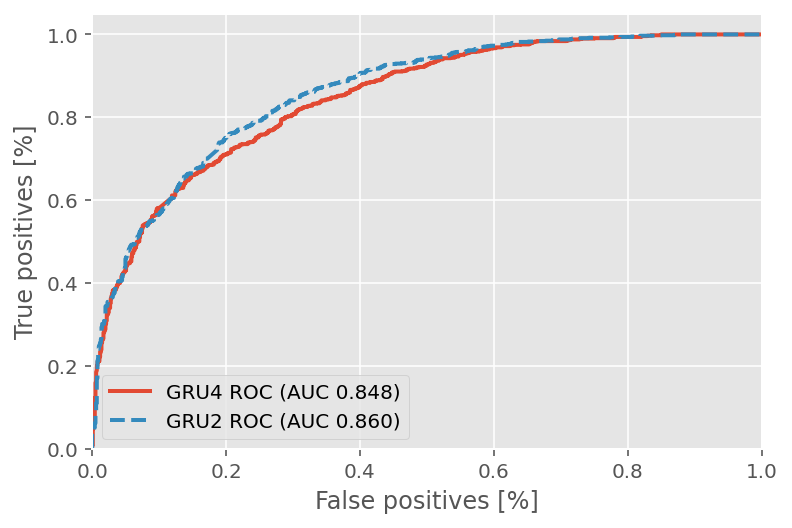

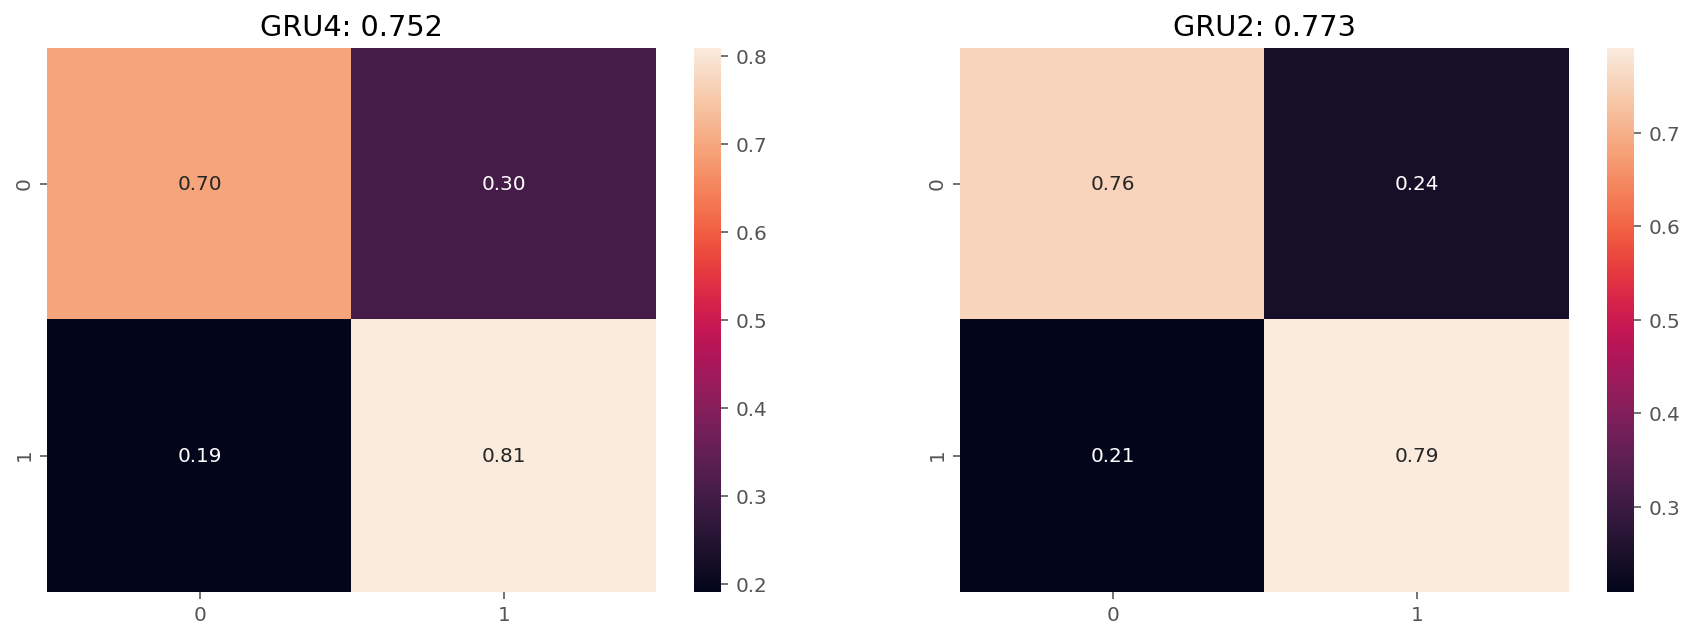

The difference of GRU4 and GRU2 is -0.005367901198237202,0.047367901198237236 


In [31]:
compare_model(rnn6_eval,rnn4_eval,rnn6.name,rnn4.name)